# Imports and Helper Functions

In [1]:
import multiprocessing
num_available_cpus = multiprocessing.cpu_count()

print("Number of available CPUs:", num_available_cpus)

import sys

import math
import time
import tqdm

import numpy as np
import scipy as sp
from scipy import stats
from scipy.spatial import ConvexHull

import itertools
import logging
import matplotlib.pyplot as plt

import pandas as pd
import h5py

from sklearn import metrics

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from torch.distributions import MultivariateNormal
import torch.utils.data as utils

from argparse import ArgumentParser
import re

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

Number of available CPUs: 80


In [2]:
from nflows.flows.base import Flow
from nflows.flows.autoregressive import MaskedAutoregressiveFlow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform, MaskedPiecewiseQuadraticAutoregressiveTransform, MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

In [3]:
from helper_functions import *

In [4]:
torch.cuda.empty_cache()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device =", device)
torch.set_default_tensor_type('torch.cuda.FloatTensor') if torch.cuda.is_available() else print ('cpu')

torch.set_num_threads(num_available_cpus)

print("Number of threads:", torch.get_num_threads())
print("Number of interop threads:", torch.get_num_interop_threads())

Device = cuda:0
Number of threads: 80
Number of interop threads: 80


# Load models

In [5]:
num_features = 14
hidden_features = 56

num_layers = 4
num_blocks_per_layer = 4
#num_iter = 10000
num_iter = 1000
print_interval = 20

#Current flow_type options: 'MAF', 'NSQUAD' (neural spline quadratic), 'NSRATQUAD' (neural spline rational quadratic)
flow_type = 'NSQUAD'

study = 'BB'

In [6]:
filename = 'Pure_NF_%s_k%s_hf%s_nbpl%s' % (flow_type, num_layers, hidden_features, num_blocks_per_layer)

if study == 'BB': 
    bkg_model = torch.load("pure_flows/bkg_%s.pt" % (filename))
    sig_model = torch.load("pure_flows/sig_%s.pt" % (filename))
else: 
    bkg_model = torch.load("new_sample_flows/%s/bkg_%s.pt" % (study, filename))
    sig_model = torch.load("new_sample_flows/%s/sig_%s.pt" % (study, filename))

# Load and Process Samples

In [7]:
num_bkg_batches = 2
if study == 'BB': 
    num_sig_batches = 5
else: 
    num_sig_batches = 1

num_top_MB_batches = 9
num_ttbar_MB_batches = 2
num_vjets_MB_batches = 1

In [8]:
bkg_data, bkg_unnorm_data, bkg_masses = LAPS_test(sample_type = 'qcdbkg', num_batches = num_bkg_batches)
print(bkg_data.shape)
bkg_mean = np.mean(bkg_unnorm_data, axis=0)
bkg_std = np.std(bkg_unnorm_data, axis=0)

bkgtr_bkg_losses = -bkg_model.log_prob(bkg_data)[0].detach().cpu().numpy()
sigtr_bkg_losses = -sig_model.log_prob(bkg_data)[0].detach().cpu().numpy()

integer distribution detected...
integer distribution detected...
(397276, 14)


In [9]:
sig_data, sig_unnorm_data, sig_masses = LAPS_test(sample_type = 'wprimesig', num_batches = num_sig_batches, inp_meanstd = (bkg_mean, bkg_std))

sig_num_samples = sig_data.shape[0]
if study == 'BB': 
    sampling_indices = np.random.randint(sig_num_samples, size = int(0.158 * sig_num_samples))
else: 
    sampling_indices = np.random.randint(sig_num_samples, size = int(0.05 * sig_num_samples))

sig_data = sig_data[sampling_indices, :]
sig_unnorm_data = sig_unnorm_data[sampling_indices, :]
sig_masses = sig_masses[sampling_indices, :]

print(sig_data.shape)
bkgtr_sig_losses = -bkg_model.log_prob(sig_data)[0].detach().cpu().numpy()
sigtr_sig_losses = -sig_model.log_prob(sig_data)[0].detach().cpu().numpy()

integer distribution detected...
integer distribution detected...
(533, 14)


In [10]:
top_MB_data, top_MB_unnorm_data, top_MB_masses = LAPS_test(sample_type = 'top_MB', num_batches = num_top_MB_batches, inp_meanstd = (bkg_mean, bkg_std))

top_MB_num_samples = top_MB_data.shape[0]
sampling_indices = np.random.randint(top_MB_num_samples, size = top_MB_num_samples)
top_MB_data = top_MB_data[sampling_indices, :]
top_MB_unnorm_data = top_MB_unnorm_data[sampling_indices, :]
top_MB_masses = top_MB_masses[sampling_indices, :]

print(top_MB_data.shape)
bkgtr_top_MB_losses = -bkg_model.log_prob(top_MB_data)[0].detach().cpu().numpy()
sigtr_top_MB_losses = -sig_model.log_prob(top_MB_data)[0].detach().cpu().numpy()

integer distribution detected...
integer distribution detected...
(973, 14)


In [11]:
ttbar_MB_data, ttbar_MB_unnorm_data, ttbar_MB_masses = LAPS_test(sample_type = 'ttbar_MB', num_batches = num_ttbar_MB_batches, inp_meanstd = (bkg_mean, bkg_std))

ttbar_MB_num_samples = ttbar_MB_data.shape[0]
sampling_indices = np.random.randint(ttbar_MB_num_samples, size = ttbar_MB_num_samples)
ttbar_MB_data = ttbar_MB_data[sampling_indices, :]
ttbar_MB_unnorm_data = ttbar_MB_unnorm_data[sampling_indices, :]
ttbar_MB_masses = ttbar_MB_masses[sampling_indices, :]

print(ttbar_MB_data.shape)
bkgtr_ttbar_MB_losses = -bkg_model.log_prob(ttbar_MB_data)[0].detach().cpu().numpy()
sigtr_ttbar_MB_losses = -sig_model.log_prob(ttbar_MB_data)[0].detach().cpu().numpy()

integer distribution detected...
integer distribution detected...
(998, 14)


In [12]:
vjets_MB_data, vjets_MB_unnorm_data, vjets_MB_masses = LAPS_test(sample_type = 'vjets_MB', num_batches = num_vjets_MB_batches, inp_meanstd = (bkg_mean, bkg_std))

vjets_MB_num_samples = vjets_MB_data.shape[0]
sampling_indices = np.random.randint(vjets_MB_num_samples, size = int(0.3 * vjets_MB_num_samples))
vjets_MB_data = vjets_MB_data[sampling_indices, :]
vjets_MB_unnorm_data = vjets_MB_unnorm_data[sampling_indices, :]
vjets_MB_masses = vjets_MB_masses[sampling_indices, :]

print(vjets_MB_data.shape)
bkgtr_vjets_MB_losses = -bkg_model.log_prob(vjets_MB_data)[0].detach().cpu().numpy()
sigtr_vjets_MB_losses = -sig_model.log_prob(vjets_MB_data)[0].detach().cpu().numpy()

integer distribution detected...
integer distribution detected...
(981, 14)


# Master QUAK Space

In [25]:
x_bad_loss_cutoff = 100
y_bad_loss_cutoff = 100

In [26]:
plt.rcParams["figure.figsize"] = (10,10)

In [27]:
bkgtr_bkg_losses = np.append(bkgtr_bkg_losses, np.array([0,]))
sigtr_bkg_losses = np.append(sigtr_bkg_losses, np.array([0,]))

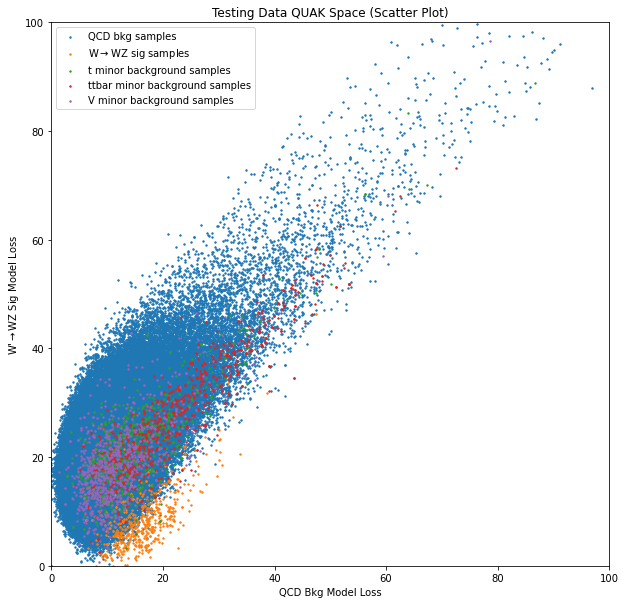

In [28]:
plt.scatter(bkgtr_bkg_losses, sigtr_bkg_losses, s=2, label = 'QCD bkg samples')
plt.scatter(bkgtr_sig_losses, sigtr_sig_losses, s=2, label = r'''W$\rightarrow$WZ sig samples''')
plt.scatter(bkgtr_top_MB_losses, sigtr_top_MB_losses, s=2, label = r'''t minor background samples''')
plt.scatter(bkgtr_ttbar_MB_losses, sigtr_ttbar_MB_losses, s=2, label = r'''ttbar minor background samples''')
plt.scatter(bkgtr_vjets_MB_losses, sigtr_vjets_MB_losses, s=2, label = r'''V minor background samples''')
plt.xlim(0, x_bad_loss_cutoff)
plt.ylim(0, y_bad_loss_cutoff)
plt.xlabel('QCD Bkg Model Loss')
plt.ylabel(r'''W'$\rightarrow$WZ Sig Model Loss''')
#plt.ylabel(r'''Wkk$\rightarrow$WR$\rightarrow$W+WW (M=2000) Sig Model Loss''')
plt.title('Testing Data QUAK Space (Scatter Plot)')
plt.legend()
plt.show()

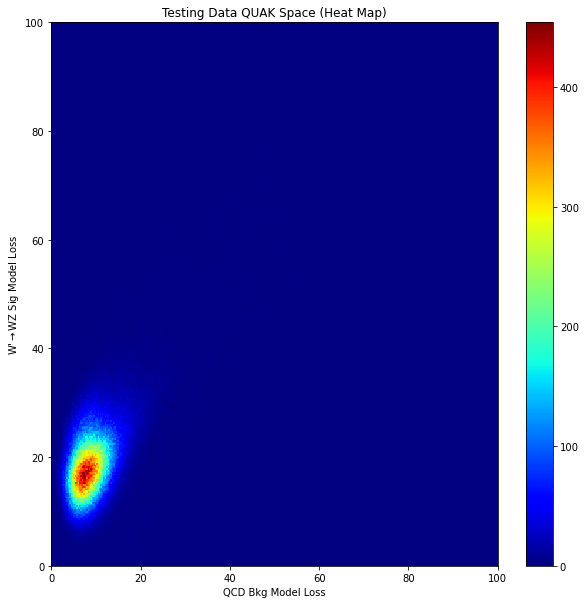

In [29]:
num_bins = 2000

bkgtr_all_losses = np.concatenate((bkgtr_bkg_losses, bkgtr_sig_losses, bkgtr_top_MB_losses, bkgtr_ttbar_MB_losses, bkgtr_vjets_MB_losses))
sigtr_all_losses = np.concatenate((sigtr_bkg_losses, sigtr_sig_losses, sigtr_top_MB_losses, sigtr_ttbar_MB_losses, sigtr_vjets_MB_losses))

plt.hist2d(bkgtr_all_losses, sigtr_all_losses, cmap = plt.cm.jet, bins=num_bins)
plt.colorbar()
plt.xlabel('QCD Bkg Model Loss')
plt.ylabel(r'''W'$\rightarrow$WZ Sig Model Loss''')
plt.title('Testing Data QUAK Space (Heat Map)')
plt.xlim(0, x_bad_loss_cutoff)
plt.ylim(0, y_bad_loss_cutoff)
plt.show()

# Normalized Input Variable Density Histograms

In [18]:
plt.rcParams["figure.figsize"] = (5,5)

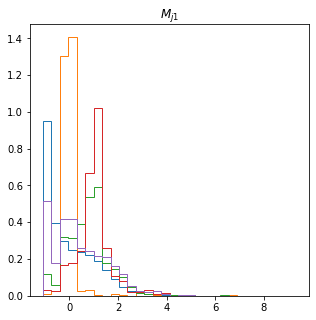

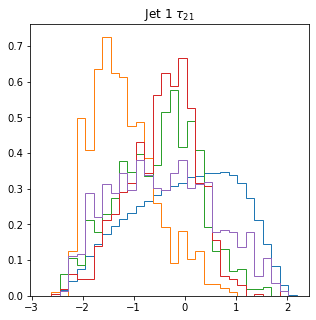

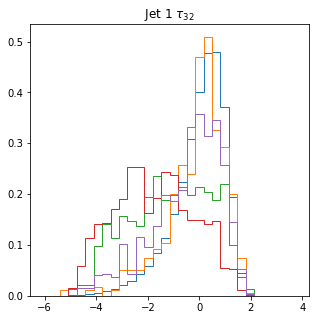

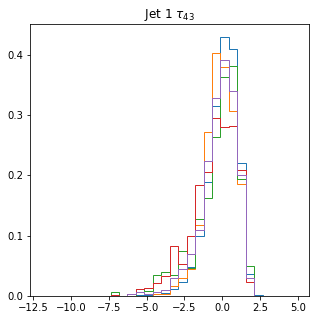

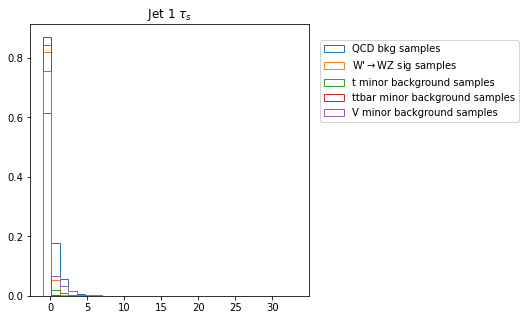

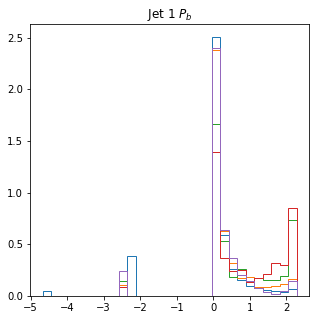

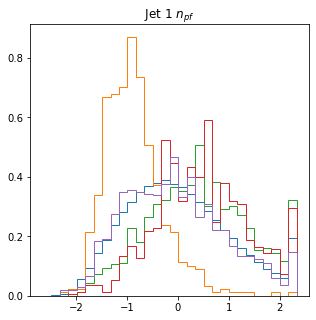

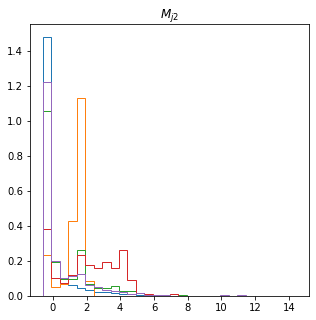

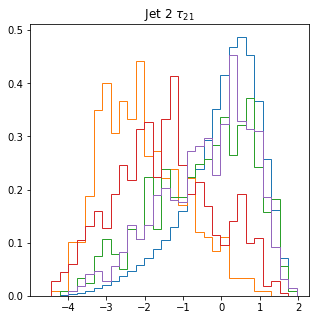

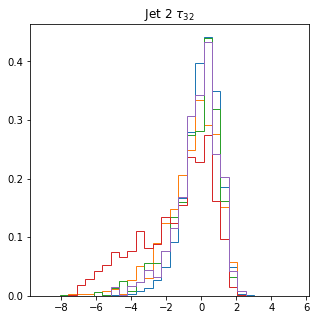

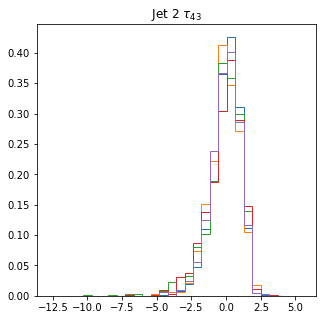

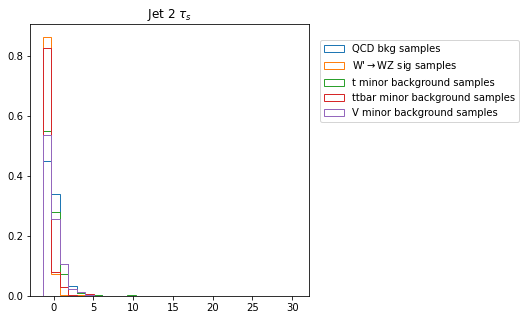

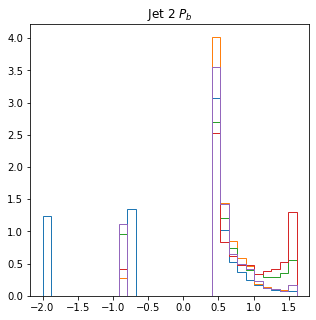

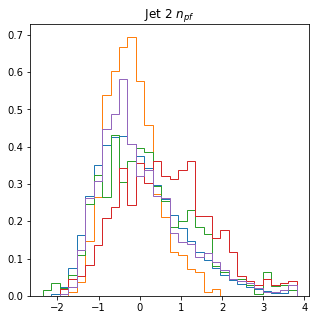

In [19]:
plot_titles = [r'$M_{j1}$', r'Jet 1 $\tau_{21}$', r'Jet 1 $\tau_{32}$', r'Jet 1 $\tau_{43}$', r'Jet 1 $\tau_s$', r'Jet 1 $P_b$', r'Jet 1 $n_{pf}$', 
              r'$M_{j2}$', r'Jet 2 $\tau_{21}$', r'Jet 2 $\tau_{32}$', r'Jet 2 $\tau_{43}$', r'Jet 2 $\tau_s$', r'Jet 2 $P_b$', r'Jet 2 $n_{pf}$',]

for index in range(num_features): 
    n, bins, patches = plt.hist(bkg_data[:, index], bins=30, histtype='step', density=True, label='QCD bkg samples')
    plt.hist(sig_data[:, index], bins=bins, histtype='step', density=True, label=r'''W'$\rightarrow$WZ sig samples''')
    plt.hist(top_MB_data[:, index], bins=bins, histtype='step', density=True, label=r'''t minor background samples''')
    plt.hist(ttbar_MB_data[:, index], bins=bins, histtype='step', density=True, label=r'''ttbar minor background samples''')
    plt.hist(vjets_MB_data[:, index], bins=bins, histtype='step', density=True, label=r'''V minor background samples''')
    if index % 7 == 4: 
        plt.legend(loc=(1.04,0.64))
    plt.title(plot_titles[index])
    plt.show()